In [73]:
from iminuit import Minuit
from math import log10, floor
from scipy import integrate
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os, sys

class mixing_fitter:
    """
    Class that can fit gaussians to data. You have to enter the data in the gaussian_fit function, and the fitted values and errors on the values
    get stored in the class.
    """
    def __init__(self):
        self.fitted_values = []
        self.fitted_err = []
        
    def gaussian(self, mean, sigma): #Just normal distribution
        return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5* ((self.data_to_fit-mean)/sigma)**2)
        
    def log_like_hood_gaussian(self, mean, sigma): # Loglikelihood of normal distribution
        return -np.sum(np.log(self.gaussian(mean, sigma)))

    def gaussian_fit(self, data, t = np.linspace(-0.025, 0.025, 10000)):
        self.data_to_fit = data
        fit_gaussian = Minuit(self.log_like_hood_gaussian, mean = np.mean(self.data_to_fit), sigma = np.std(self.data_to_fit))
        fit_gaussian.limits["sigma"] = (0, np.inf)
        fit_gaussian.errordef = Minuit.LIKELIHOOD
        fit_gaussian.migrad()
        fit_gaussian.hesse()
        if fit_gaussian.valid == True:
            self.data_to_fit = t
            gaussian_outcome = self.gaussian(*fit_gaussian.values) # Makes a curve of the gaussian that has just been fitted
            mean, sigma = fit_gaussian.values
            mean_err, sigma_err = fit_gaussian.errors
            self.fitted_values.append([self.round(mean, sig = 3), self.round(sigma, sig = 3)])
            self.fitted_err.append([self.round(mean_err, sig = 2), self.round(sigma_err, sig = 2)])
            return fit_gaussian, gaussian_outcome, t
        else:
            print("Wrong fit")

    def round(self, x, sig=2):
        # Rounds to a certain number of significant events
        return round(x, sig-int(floor(log10(abs(x))))-1)



In [77]:

def Load_toys(Directory):
    # Loads in the toy models. Only x and y are kept, divided by 10 such that the values are recovered as "percentages". 
    # Because the toy model recovers them as x = 4 and y = 6
    
    vs = []
    errs = []
    fmins = []
    covs = []
    pars = []
    for i in range(100):
        with open(Directory + f'/toy{i}/fit_results.pkl' , 'rb') as f:
            fmins.append(pickle.load(f))
            vs.append(pickle.load(f))
            errs.append(pickle.load(f))
            covs.append(pickle.load(f))
            pars.append(pickle.load(f))

    x = []
    y = []
    for i in range(100):
        x.append(vs[i]['x35'])
        y.append(vs[i]['x36'])

    return np.array(x)/10, np.array(y)/10



x_orig, y_orig = Load_toys(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_fixmc_toys')
x_smeared_1, y_smeared_1 = Load_toys(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_fixmc_smearing_method_1_toys')
x_smeared_2, y_smeared_2 = Load_toys(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_smearing_method_2_toys')

#x_orig, y_orig = Load_toys(f'C:/Users/bnijm/Documents/Root/sig_mistag_comb_bootstrapmc_toys')


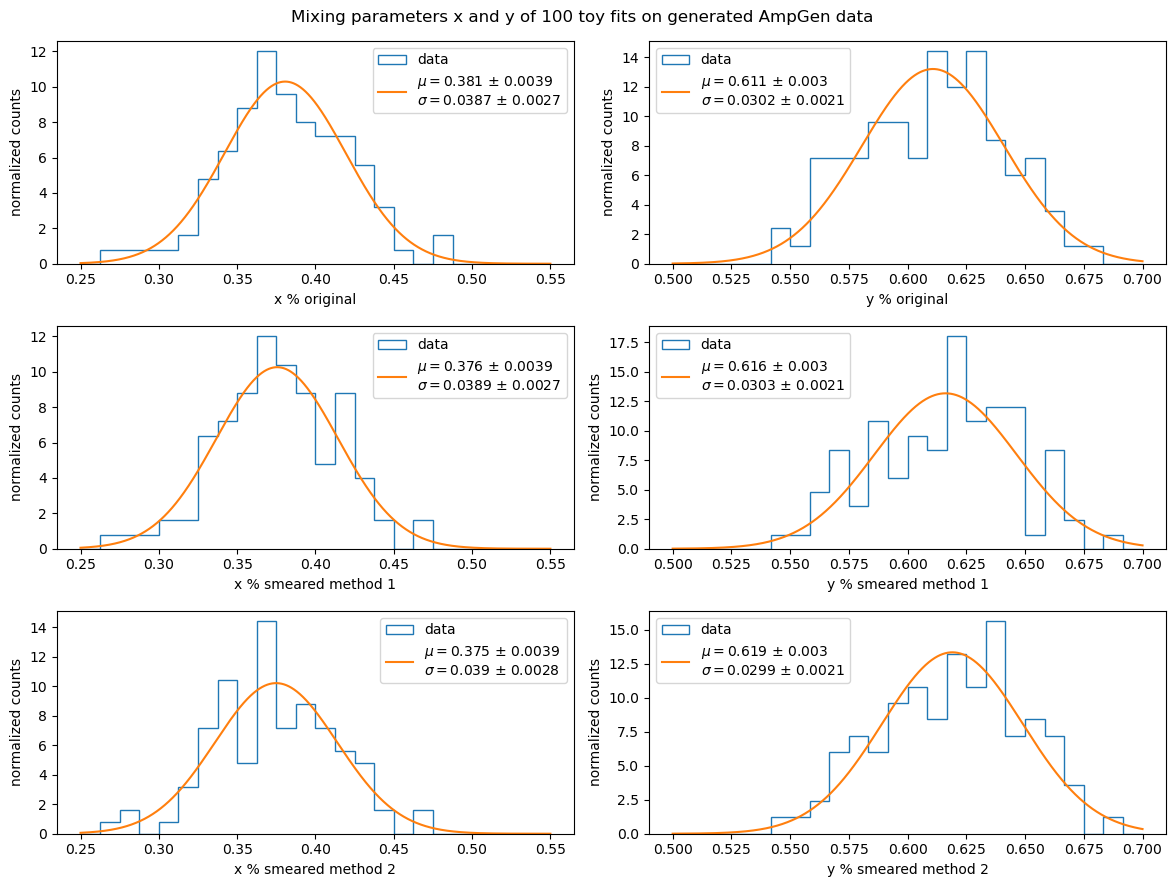

In [80]:
n_bins = 20
fig, ax = plt.subplots(3,2, figsize = (12,9))

x_datas = [x_orig, x_smeared_1, x_smeared_2]
y_datas = [y_orig, y_smeared_1, y_smeared_2]

x_bins = np.linspace(0.25, 0.55, 25)


fitter_x = mixing_fitter()
fitter_y = mixing_fitter()

labels = ["original", "smeared method 1", "smeared method 2"]

for i in range(3):
    Minuit_fit_x, distribution_fit_x, t_fit_x = fitter_x.gaussian_fit(data = x_datas[i], t = np.linspace(0.25,0.55,10000))
    Minuit_fit_y, distribution_fit_y, t_fit_y = fitter_y.gaussian_fit(data = y_datas[i], t = np.linspace(0.5,0.7,10000))
    
    ax[i,0].hist(x_datas[i], bins = x_bins, histtype = "step", density = True, label = "data")
    ax[i,0].plot(t_fit_x, distribution_fit_x, label = r"$\mu = $" + f"{fitter_x.fitted_values[i][0]} \u00B1 {fitter_x.fitted_err[i][0]} \n" 
                 +r"$\sigma = $" + f"{fitter_x.fitted_values[i][1]} \u00B1 {fitter_x.fitted_err[i][1]}" )
    #ax[i,0].axvline(x=0.4, color = 'r', ymax = 0.1, label = "generated value x")
    ax[i,0].set(ylabel = "normalized counts", xlabel = "x % " + labels[i])
    ax[i,0].legend()

    ax[i,1].hist(y_datas[i], bins = y_bins, histtype = "step", density = True, label = "data")
    ax[i,1].plot(t_fit_y, distribution_fit_y, label = r"$\mu = $" + f"{fitter_y.fitted_values[i][0]} \u00B1 {fitter_y.fitted_err[i][0]} \n" 
                 +r"$\sigma = $" + f"{fitter_y.fitted_values[i][1]} \u00B1 {fitter_y.fitted_err[i][1]}" )
    #ax[i,1].axvline(x=0.6, color = 'b', ymax = 0.1, label = "generated value y")
    ax[i,1].set(ylabel = "normalized counts", xlabel = "y % " + labels[i])
    ax[i,1].legend()


plt.suptitle('Mixing parameters x and y of 100 toy fits on generated AmpGen data')
fig.tight_layout()
plt.show()

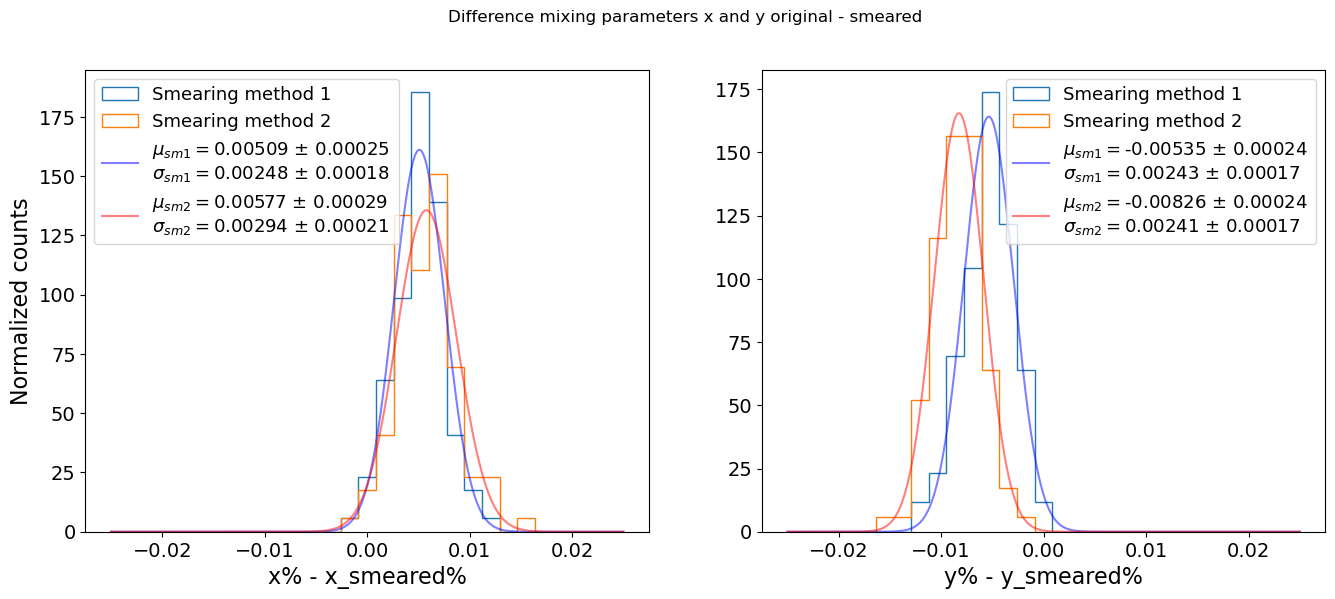

In [82]:
fitter = mixing_fitter()

x_diff_1_fit, x_diff_1_outcome, t = fitter.gaussian_fit(data =x_orig - x_smeared_1)
x_diff_2, x_diff_2_outcome, t  = fitter.gaussian_fit(data =x_orig - x_smeared_2)

y_diff_1_fit, y_diff_1_outcome, t = fitter.gaussian_fit(data =y_orig - y_smeared_1)
y_diff_2, y_diff_2_outcome, t  = fitter.gaussian_fit(data =y_orig - y_smeared_2)

fit_val = fitter.fitted_values
fit_err = fitter.fitted_err

n_bins = np.linspace(-0.025, 0.025, 30)

fig, ax = plt.subplots(1,2, figsize = (16,6))

ax[0].hist(x_orig - x_smeared_1, bins = n_bins, histtype = 'step', label = "Smearing method 1", density = True)
ax[0].hist(x_orig - x_smeared_2, bins = n_bins, histtype = 'step', label = "Smearing method 2", density = True)

ax[0].plot(t, x_diff_1_outcome, color ='b', alpha = 0.5, linewidth = 1.5, label = r"$\mu_{sm1} = $" + f"{fit_val[0][0]} \u00B1 {fit_err[0][0]} \n" +r"$\sigma_{sm1} = $" + f"{fit_val[0][1]} \u00B1 {fit_err[0][1]} " )
ax[0].plot(t, x_diff_2_outcome, color ='r', alpha = 0.5, linewidth = 1.5, label = r"$\mu_{sm2} = $" + f"{fit_val[1][0]} \u00B1 {fit_err[1][0]} \n" +r"$\sigma_{sm2} = $" + f"{fit_val[1][1]} \u00B1 {fit_err[1][1]} " )
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(fontsize = 13, loc = "upper left")

ax[1].hist(y_orig- y_smeared_1, bins = n_bins, histtype = 'step', label = "Smearing method 1", density = True)
ax[1].hist(y_orig - y_smeared_2, bins = n_bins, histtype = 'step', label = "Smearing method 2", density = True)

ax[1].plot(t, y_diff_1_outcome, color ='b', alpha = 0.5, linewidth = 1.5, label = r"$\mu_{sm1} = $" + f"{fit_val[2][0]} \u00B1 {fit_err[2][0]} \n" +r"$\sigma_{sm1} = $" + f"{fit_val[2][1]} \u00B1 {fit_err[2][1]} " )
ax[1].plot(t, y_diff_2_outcome, color ='r', alpha = 0.5, linewidth = 1.5, label = r"$\mu_{sm2} = $" + f"{fit_val[3][0]} \u00B1 {fit_err[3][0]} \n" +r"$\sigma_{sm2} = $" + f"{fit_val[3][1]} \u00B1 {fit_err[3][1]} " )

ax[1].legend(loc = "upper right", fontsize = 13)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel('x% - x_smeared%', fontsize = 16)
ax[0].set_ylabel('Normalized counts', fontsize = 16)
ax[1].set_xlabel('y% - y_smeared%', fontsize = 16)
plt.suptitle('Difference mixing parameters x and y original - smeared')
#plt.savefig("Biasplot")
plt.show()

100 100
0.3729294119135612


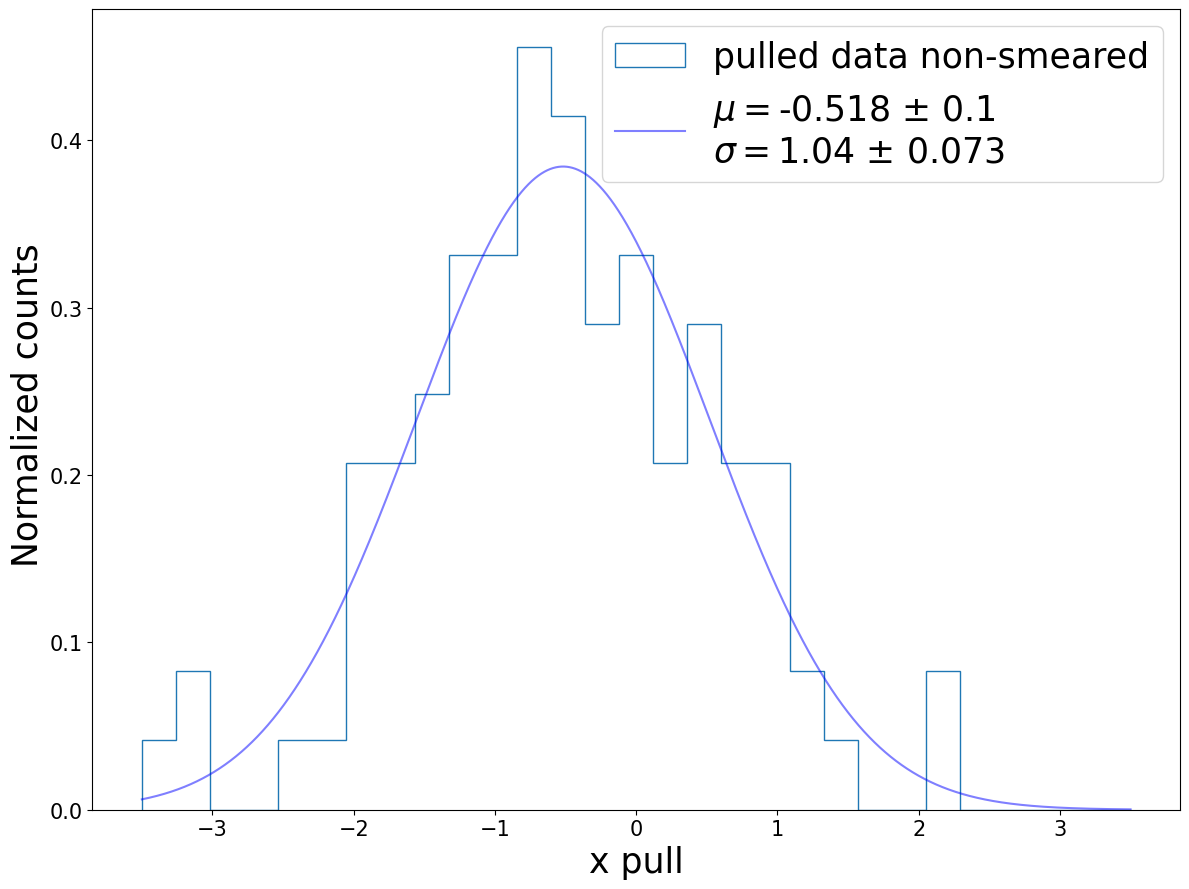

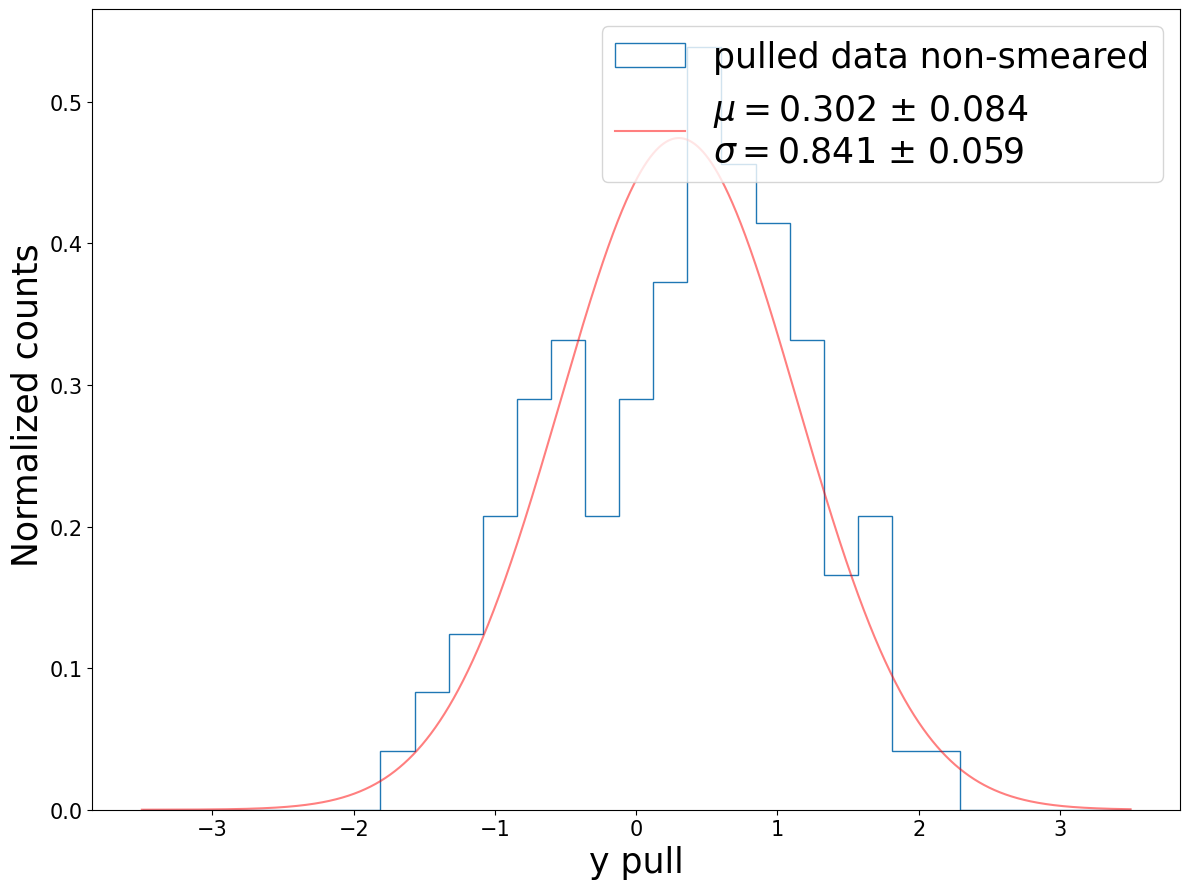

100 100
0.3740808329249136


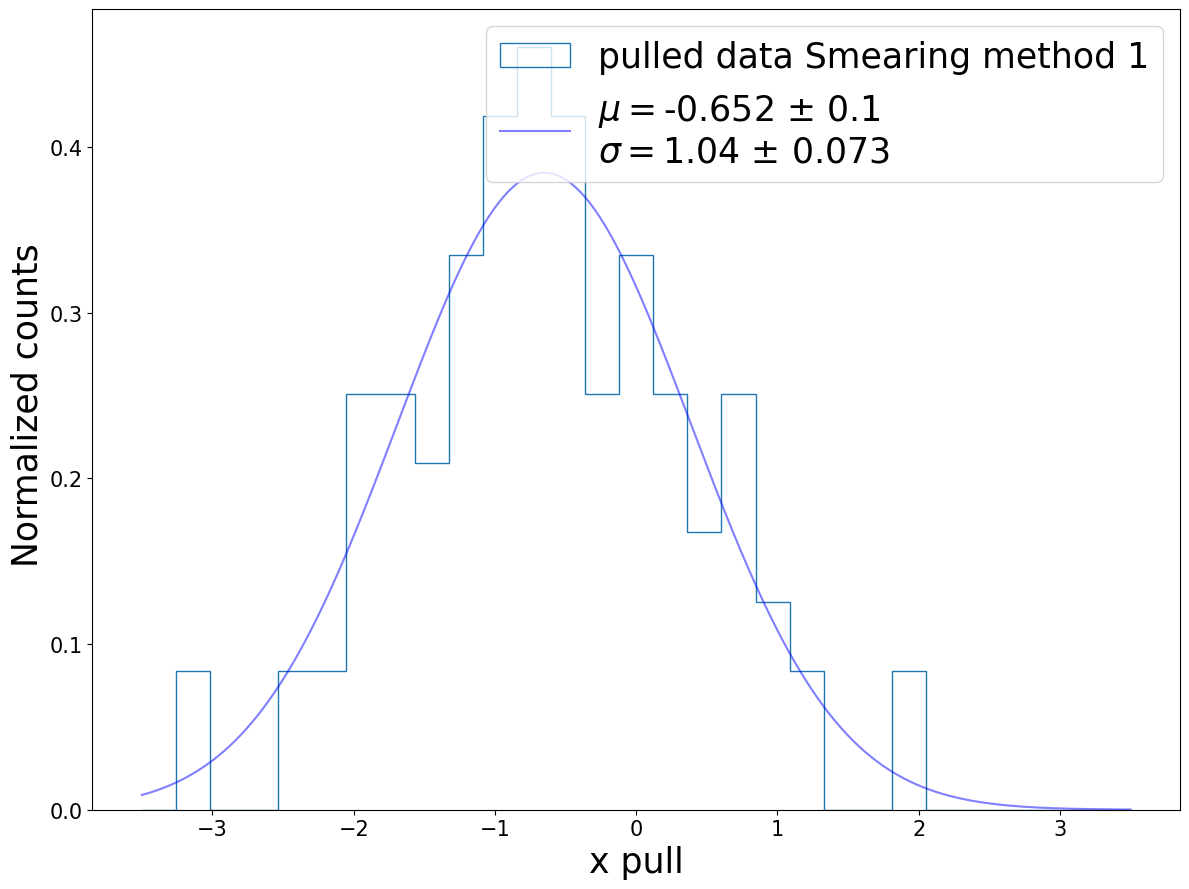

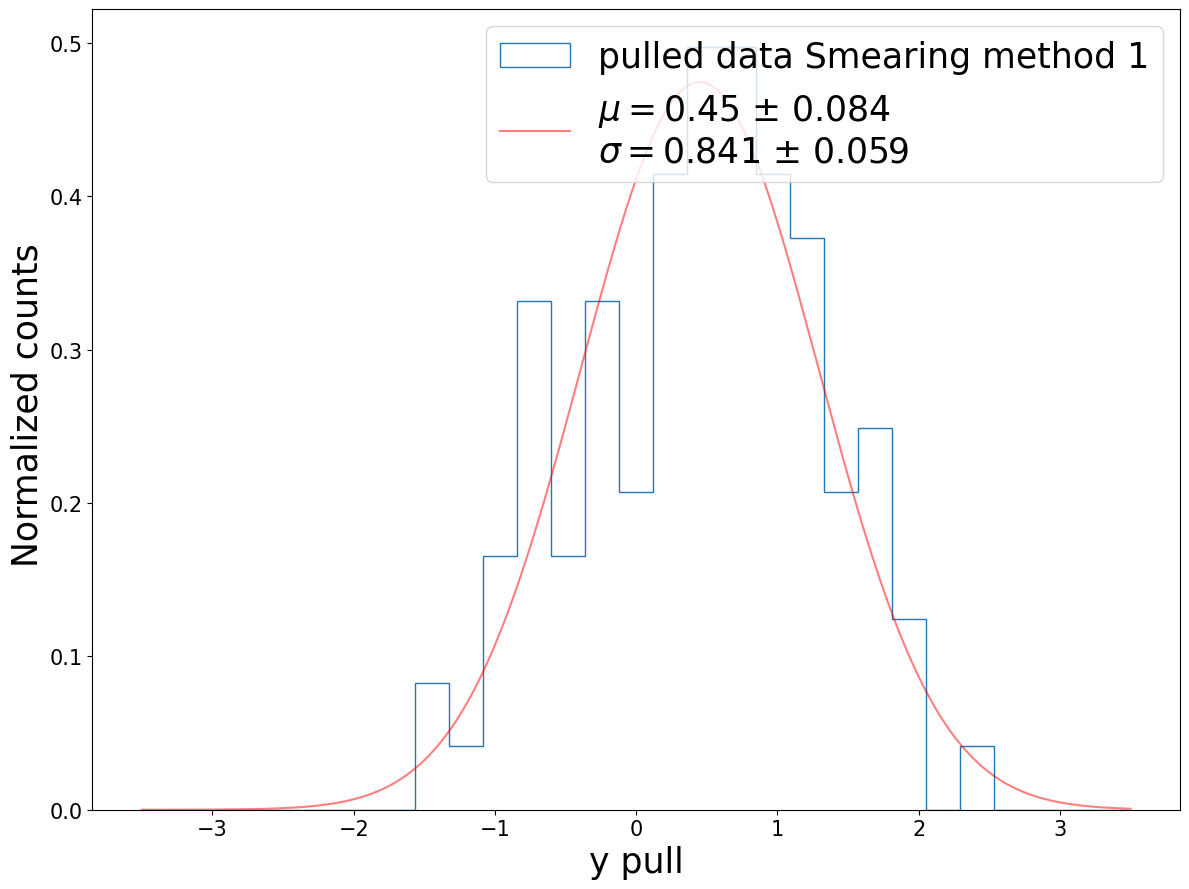

100 100
0.3742096657046905


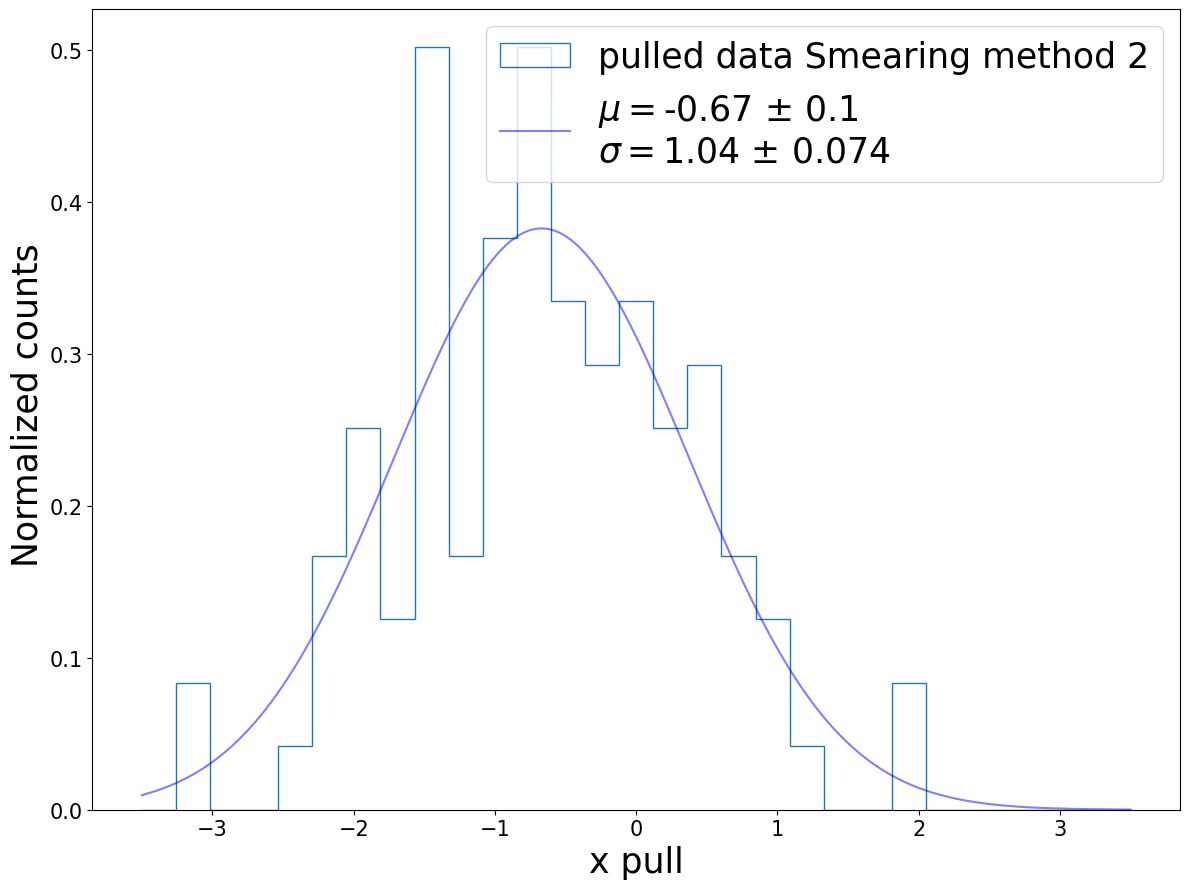

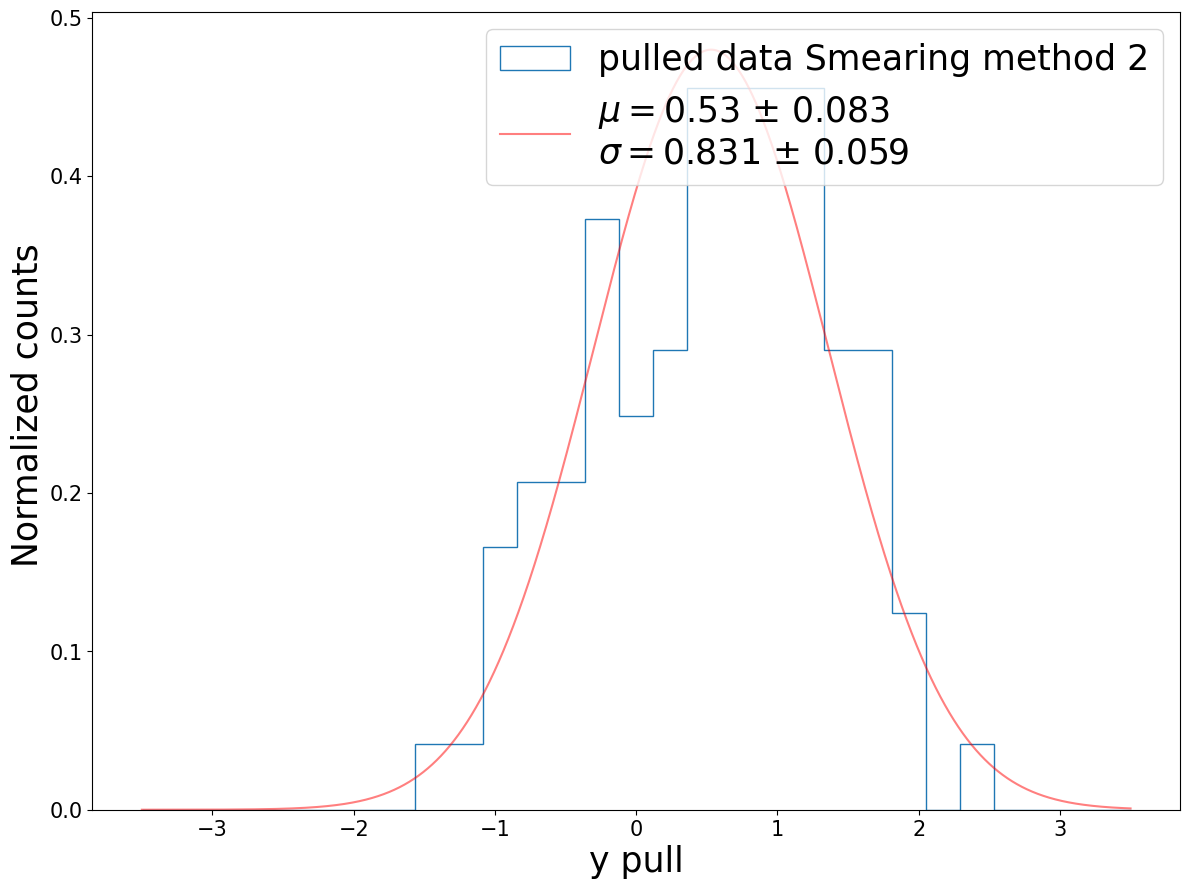

In [84]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
import os, sys

def Plot_pulls(Directory, type):
    vs = []
    errs = []
    fmins = []
    covs = []
    pars = []
    for i in range(100):
        with open(Directory + f'/toy{i}/fit_results.pkl' , 'rb') as f:
            fmins.append(pickle.load(f))
            vs.append(pickle.load(f))
            errs.append(pickle.load(f))
            covs.append(pickle.load(f))
            pars.append(pickle.load(f))
            
    accurate_fmins = [fmin for fmin in fmins if fmin.has_accurate_covar]
    print(len(fmins), len(accurate_fmins))
    x = []
    y = []
    
    ex = []
    ey = []
    for i in range(100):
        x.append(vs[i]['x35'])
        ex.append(errs[i]['x35'])
        y.append(vs[i]['x36'])
        ey.append(errs[i]['x36'])
    pull_x = (np.array(x) - 4)/np.array(ex)   
    pull_y = (np.array(y) - 6)/np.array(ey)
    print(np.mean(np.array(ex)))

    fitter = mixing_fitter()
    x_fit, x_outcome, t = fitter.gaussian_fit(data =pull_x, t = np.linspace(-3.5,3.5,10000))
    y_fit, y_outcome, t = fitter.gaussian_fit(data =pull_y, t = np.linspace(-3.5,3.5,10000))
    n_bins = np.linspace(-3.5, 3.5, 30)

    
    fig, ax = plt.subplots(1,1, figsize = (12,9))

    ax.hist(pull_x, bins = n_bins, histtype = 'step', label = "pulled data " + type, density = True)
    ax.plot(t, x_outcome, color ='b', alpha = 0.5, label = r"$\mu = $" + f"{fitter.fitted_values[0][0]} \u00B1 {fitter.fitted_err[0][0]} \n" 
                 +r"$\sigma = $" + f"{fitter.fitted_values[0][1]} \u00B1 {fitter.fitted_err[0][1]}" )
    ax.legend(loc = "upper right", fontsize = 25)
    ax.set_xlabel( "x pull", fontsize = 25)
    ax.set_ylabel(" Normalized counts", fontsize = 25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    fig.tight_layout()
    #plt.savefig("Originalpullx")
    plt.show()

    fig, ax = plt.subplots(1,1, figsize = (12,9))

    ax.hist(pull_y, bins = n_bins, histtype = 'step', label = "pulled data " + type, density = True)
    ax.plot(t, y_outcome, color ='r', alpha = 0.5, label = r"$\mu = $" + f"{fitter.fitted_values[1][0]} \u00B1 {fitter.fitted_err[1][0]} \n" 
                 +r"$\sigma = $" + f"{fitter.fitted_values[1][1]} \u00B1 {fitter.fitted_err[1][1]}" )
    ax.legend(loc = "upper right", fontsize = 25)
    
    ax.set_xlabel( "y pull", fontsize = 25)
    ax.set_ylabel(" Normalized counts", fontsize = 25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    #plt.suptitle('Plots of pulls of x and y for 100 toys')
    fig.tight_layout()
    #plt.savefig("Originalpully")
    plt.show()

    
Plot_pulls(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_fixmc_toys', type = "non-smeared")
Plot_pulls(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_fixmc_smearing_method_1_toys', type = "Smearing method 1")
Plot_pulls(f'C:/Users/bnijm/Documents/Root/Toy_models/sig_mistag_comb_smearing_method_2_toys', type = "Smearing method 2")
